# MMNG NOTEBOOK FOR ADA PROJECT
## This notebook contains the exploratory data analysis that we perfomed on the data necessary to our project. The following analysis is performed on the Quotebank data of 2020.
Note that we also performed some small analysis on the whole dataset that can be found in a second notebook named ?
Note that the preprocessing is done in separate .py files that we just need to run once to create the processed data files. However, preprocessing steps will also be described in detail within this notebook.

The data we need is in both Quotebank and wikidata. From quotebank we extract quotes, speakers and dates. From Wikidata we extract the political party corresponding to the speakers. Below we will present the exploration of the data that are useful to us. The goal of this notebook is to show our initial treatment of the data: the preprocessing and all the necessary descriptive statistics tasks. 

The first thing we need to do is to merge the two datasets in order to label the quotes with the political party associated. 
The merging pipeline is described below. We write the resulting merged data into a file accessible at path QUOTES_2020_PARTY_LABELED_PATH.

MERGING PIPELINE

In [4]:
!pip install pandas==1.3.0

In [1]:
%load_ext autoreload
%autoreload 2
from helpers import *
from drop_similar_quotes import *

import pandas as pd
import bz2
import json
import texthero as hero
import datetime
from texthero import preprocessing as hp
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

Now that we merged the file we can see how the datas are organized:

In [6]:
#Printing the first  4 lines of the file located at path.
def print_n_lines(path,n):
    flag = 0
    with bz2.open(path_to_file, 'rb') as s_file:
          for instance in s_file:   
                if flag < n:
                    instance = json.loads(instance) # loading a sample
                    print(instance)
                    print('-----------------------------------------')
                    flag +=1
                else:
                    break
                    
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 
print_n_lines(path_to_file,4)

{'quoteID': '2020-01-16-000088', 'quotation': '[ Department of Homeland Security ] was livid and strongly urged to have the agenda pulled.', 'speaker': 'Sue Myrick', 'date': 1579176013000, 'numOccurrences': 1, 'id': 'Q367796', 'party_label': 'R', 'US_congress_bio_ID': 'M001134'}
-----------------------------------------
{'quoteID': '2020-01-26-000499', 'quotation': 'a few of the candidates who will do better in our part of the world', 'speaker': 'Dave Loebsack', 'date': 1580044896000, 'numOccurrences': 11, 'id': 'Q771586', 'party_label': 'D', 'US_congress_bio_ID': 'L000565'}
-----------------------------------------
{'quoteID': '2020-01-26-040663', 'quotation': 'The generational thing is important, quite honestly. I think we have to do everything we can to move this party forward and Pete is the future of the party,', 'speaker': 'Dave Loebsack', 'date': 1580044896000, 'numOccurrences': 11, 'id': 'Q771586', 'party_label': 'D', 'US_congress_bio_ID': 'L000565'}
---------------------------

From the fileld US_congress_bio_ID we can see if the speaker is from the congress or is just affiliated to the political party.
Note that We want to import quotations of a person, if the person occupation on the wikidata is politician (Q82955).

# DATA EXPLORATION: STUDY OF VARIOUS DISRIBUTIONS
Let's Visualize and study different data distibution, and check that everything makes sense.

## 1. Let's analyize the distribution of number of words in the quotes.

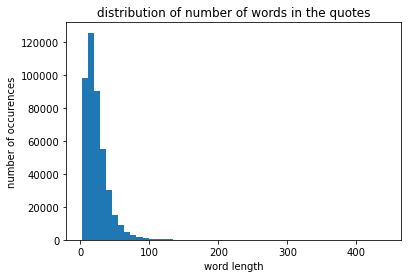

In [7]:
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

lista = []
with bz2.open(path_to_file, 'rb') as s_file:
    #For every quotation
    for instance in s_file:
        instance = json.loads(instance)
        text = instance['quotation']
        #append the length of the quotations in words.
        lista.append(len(text.split()))
        
#Plotting an histogram.
def plothisto(toPlot, xlabel,ylabel,title,bins = 50):
    plt.hist(lista, bins = bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

#Plotting an histogram of the length of the quotations in words.   
plothisto(lista, 'word length','number of occurences','distribution of number of words in the quotes',50)

If we just look at all the data everything looks kind of normal, but let's zoom on the larger values

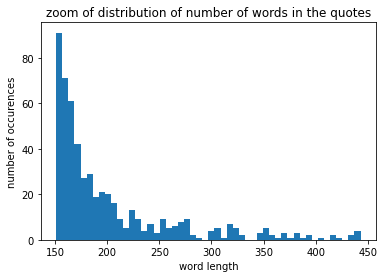

In [8]:
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

lista = []
with bz2.open(path_to_file, 'rb') as s_file:
    #For every quotation
    for instance in s_file:
        instance = json.loads(instance)
        text = instance['quotation']
        #If the quotation has more than 150 words
        if len(text.split()) > 150:
            #append the length of the quotations in words.
            lista.append(len(text.split()))

                
#Plotting an histogram of the length of the quotations in words for long quotes.   
plothisto(lista, 'word length','number of occurences','zoom of distribution of number of words in the quotes',50)

From 300 to 450 the data seems to have a distribution almost uniform but it's true that the number of quotation is low and therfore it could be fine. Lets read some of this long quotes to check if everything looks good!

In [9]:
lista = []

with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
        #For every quotation
        instance = json.loads(instance)
        text = instance['quotation']
        lista.append(len(text.split()))
        #if the length of the quote is more than 400 print the quote
        if len(text.split()) > 400:
            print(text)
            print('-------------------------------------------------------')

where the virus first emerged late last year, and which has suffered the vast majority of infections -- by imposing travel controls and shutting down public events. Italy on Saturday saw its biggest daily increase in coronavirus cases since the outbreak began in the north of the country on Feb. 21. In its daily update, Italy's civil protection agency said the number of people with the coronavirus rose by 1,247 in the last 24 hours, taking the total to 5,883. Another 36 people also died as a result of the virus, taking the total to 233. There was chaos and confusion in the northern Italian city of Padua in the Veneto region as word spread late Saturday evening that the government was planning to announce the quarantine. Packed bars and restaurants quickly emptied out as many people rushed to the train station in Padua. Travellers with suitcases, wearing face masks, gloves and carrying bottles of sanitizing gel shoved their way on to trains. Before Conte signed the quarantine decree, Ste

Most of the quotes looks good, even if some are clearly not quotes (look at the last one), but many contains 'â € ','â € ™','â € ' and other wird sequences of characters! Let's count how many there are in our 2020 filtered dataset.

In [10]:
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

#counter
cnt = 0
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            #For every quotation
            instance = json.loads(instance)
            text = instance['quotation']
            #if the text contains some wird characters increment the counter
            if 'â € ' in text or 'â € ™' in text:
                cnt +=1

print('The number of quotations with wird characters is: ',cnt)

The number of quotations with wird characters is:  74


A quick research on google and we convninced ourselfs that this problem is coming from a UTF-8 encoding bug when creating the datset. (see https://www.i18nqa.com/debug/utf8-debug.html) which occurs either when the dataset is created or which is present on the website from which the quote is extracted. We find strange the high concentration of these bugs within the longer citations in fact within the whole dataset we studied only 74 citations contain these bugs. Let's print the problematic char to be sure that the problem is not the jupyter notebook not supporting this special chars.

In [11]:
print('“')

“


Lastly let's check in one of the original text if the bug is alredy present using the url present in the raw dataset. Since all the urls bring us to a single website we assume that the bug is in there.

In [12]:
path_to_file = QUOTES_2020_PARTY_LABELED_COMPLETE

#We make a set  to show they are quotations from the same website
set_of_websites = set()
with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
        #For every quotation
        instance = json.loads(instance)
        text = instance['quotation']
        #if the text contains some wird characters
        if 'â € ' in text or 'â € ™' in text:
            #Add url root to the set
            set_of_websites.add(instance['urls'][0][0:27])
              
set_of_websites

{'https://medicinehatnews.com'}

Let's analyse the mean and median lenght of the sentences to see if there is a difference between republicans and democrats. 
Let's start with the median:


In [13]:
path_to_file = QUOTES_2020_PARTY_LABELED_PATH

labeled_df = pd.io.json.read_json(path_to_file, lines=True)

#return length of the quote
def length_quote(x):
    return len(x.split())

#compute the medians
labeled_df["length_quote"] = labeled_df["quotation"].apply(lambda x: length_quote(x))
medians = labeled_df.groupby(by = 'party_label')["length_quote"].median()

print(medians)

party_label
D    19.0
R    19.0
Name: length_quote, dtype: float64


Let's analyse the mean:

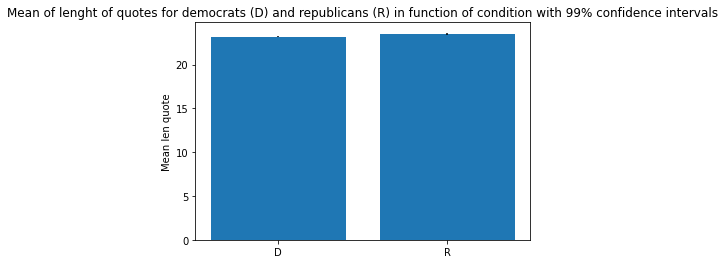

In [14]:
#Bootstrapping for quantiles. Taken from the labs.
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 0.05),np.nanpercentile(means, 99.5)]

#compute the medians
mean_dem ,mean_rep = labeled_df.groupby(by="party_label").mean()["length_quote"]

#convert to list and compute confidence intervals
party_label = labeled_df.groupby("party_label")["length_quote"].apply(lambda x : x.tolist())
[lower_dem,upper_dem] = bootstrap_CI(party_label.iloc[0],1000)
[lower_rep,upper_rep] = bootstrap_CI(party_label.iloc[1],1000)

#Plot results
plt.bar([str(party_label.index[0]),str(party_label.index[1])],[mean_dem,mean_rep],yerr = [[mean_dem-lower_dem,mean_rep-lower_rep],[upper_dem-mean_dem,upper_rep-mean_rep]])
plt.ylabel("Mean len quote")
plt.title("Mean of lenght of quotes for democrats (D) and republicans (R) in function of condition with 99% confidence intervals");

Zoom to understand if the difference is significative: in fact it is, the mean are different. We can conclude that on average the quotations of republicans are a little longer than the republican's.

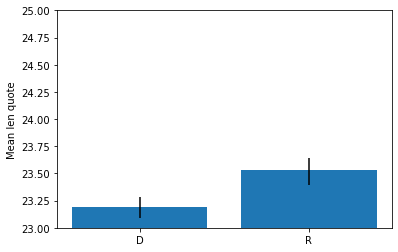

In [15]:
#Computing a zoom to see if the difference is significant

plt.bar([str(party_label.index[0]),str(party_label.index[1])],[mean_dem,mean_rep],yerr = [[mean_dem-lower_dem,mean_rep-lower_rep],[upper_dem-mean_dem,upper_rep-mean_rep]])
plt.ylabel("Mean len quote")
plt.ylim(23,25);
plt.title("ZOOM : Mean of lenght of quotes for democrats (D) and republicans (R)");

## 2. Let's analyize the distribution of number of quotes in time.

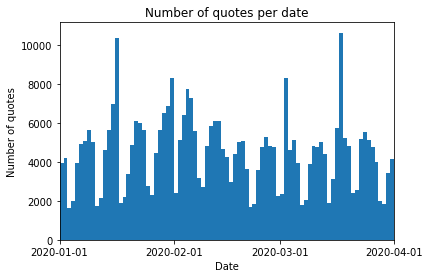

In [16]:
formatted_df = labeled_df.copy()
#change time format
formatted_df["date"] = pd.to_datetime(formatted_df['date'], format='%Y-%m-%d %H:%M:%S')

#plot the data
bins = 100
hist = plt.hist(formatted_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 3, 15), datetime.date(2020, 4, 1)])
plt.xticks([datetime.date(2020, i, 1) for i in range(1,5)])
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Number of quotes per date")
plt.show()


What are those drops? Lets check the first 2 months by printing the dates

In [17]:
#we range over two months over each day and we print the dates which have less than 3500 quotes (a bit less than the average)
for j in range(1,2):
   for i in range(1,30):
       if len(formatted_df[formatted_df.values == datetime.date(2020,j,i)]) < 3500:
           print('2020-%d-%d' % (j,i))

<ipython-input-17-bfde1d8c6e15>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if len(formatted_df[formatted_df.values == datetime.date(2020,j,i)]) < 3500:


2020-1-1
2020-1-2
2020-1-4
2020-1-5
2020-1-11
2020-1-12
2020-1-18
2020-1-19
2020-1-20
2020-1-25
2020-1-26


As we can see from these values, by checking in the calendar, these drops correspond to the weekends / holidays day, in which we assume that no quotes where inserted in the newspaper the plot.

Now lets analysis the spikes instead. We firsty get the top 10 most frequent dates of quotes, and later show them on the graph.

In [18]:
# get top 10 most frequent dates of quotes
n = 10
days_with_most_quotes = formatted_df['date'].value_counts()[:n].index.tolist()
days_with_most_quotes

[Timestamp('2020-02-05 00:00:00'),
 Timestamp('2020-02-04 00:00:00'),
 Timestamp('2020-01-15 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-01-14 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-03-24 00:00:00')]

By checking the dates with the calendar, we found that these dates are related to presidential events. Lets see some examples:
- 2020-01-15 -> the Pentagon construction was completed.
- 2020-01-30 -> President Trump signed the U.S.-Mexico-Canada (USMCA) trade pact.
- 2020-02-05: "Trump impeachment vote live updates: Sharply divided Senate acquits Trump on both articles"
- 2020-02-07 -> "United States President Donald Trump is acquitted by the United States Senate in his first impeachment trial."

Lets display them on the graph.

In [19]:
#adding events to the plot
events = {datetime.date(2020, 2, 5):'T. Imp.',
          datetime.date(2020, 1, 15): 'Pentagon',
          datetime.date(2020, 1, 30):'U-M-C'}
events_keys = []
events_values = []
for i in events.keys():
    events_keys.append(i)
for j in events.values():
    events_values.append(j)

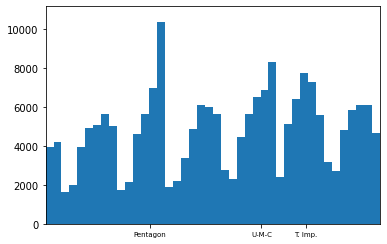

In [20]:
#replotting data
bins = 100
hist = plt.hist(formatted_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020,2, 15)])
plt.xticks([events_keys[i] for i in range(0,len(events_keys))],[events_values[i] for i in range(0,len(events_values))],fontsize=7)
plt.show()

MONO ANALYSIS

## 3.Let's analyize the words used in the quotes

MICHAEL ANALYSIS FROM ?

# DUPLICATES ANALISYS
Let's just analize if there are duplicates in the quotations. If we just take quotations as they are we cannot see any duplicates but with a bit of processing we can easily spot some...

In [21]:
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 



#Read the dataset
testdf = pd.io.json.read_json(path_to_file, lines=True)
#Put every letter to lowercase, remove whitespaces and punctuation
custom_pipeline = [hp.lowercase,
                   hp.remove_whitespace,
                   hp.remove_punctuation]
testdf['clean_quotes'] = hero.clean(testdf['quotation'], custom_pipeline)

#Check for duplicate in the original and in the cleaned version
print(testdf['quotation'].duplicated().sum())
print(testdf['clean_quotes'].duplicated().sum())
#print some duplicate sentences
testdf[testdf['clean_quotes'].duplicated()]['quotation'].head(5)

0
790


10099    jerry-rig the system and go around the Constit...
17562    There will be a huge amount of pent-up demand ...
17571    I can assure you, the president is determined,...
20314    These cameras are nothing more than a get rich...
26320        we're talking about a sharp escalation ahead.
Name: quotation, dtype: object

In [22]:
#let's visualize the two quotes: this are indeed duplicates
testdf[testdf['clean_quotes']==testdf['clean_quotes'].iloc[10099]]

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID,clean_quotes
6567,2020-02-17-041872,jerry rig the system and go around the Constit...,Stacey Abrams,2020-02-17 20:57:04,1,Q7595813,D,None,jerry rig the system and go around the constit...
10099,2020-02-19-052071,jerry-rig the system and go around the Constit...,Stacey Abrams,2020-02-19 00:00:00,2,Q7595813,D,None,jerry rig the system and go around the constit...


This means that we need to do some cleaning. Of course this analisys is not complete we need to find a more systematic way to spot duplicates. To spot duplicates we use Jaccard similarity between pairs of quotes of the same speaker. 

The pipeline for identifying highly similar quotes is fairly simple:
* Group the dataframe by speaker
* compute the jaccard similarity between pairs of quotes of a speaker. If the similarity is higher than the threshold, drop the shorter quote

Jaccard similarity is useful for identifying similar sentences. It does this by identifying the number of common words there are in both sentences.The formula is given by:

 `jaccard_similarity = size(quote_a intersection quote_b) /size(quote_a union quote_b))`

 If the `jaccard_similarity = 1`, all the words in quote_a are in quote_b and vice versa. If the `jaccard_similarity = 0`, there are no common words among both quotes. Note that Jaccard similarity 
 doesn't take into account the position of words in a sentence



Here is an example on a subset of the dataset:

In [23]:
dataframe_to_clean = pd.read_json(QUOTES_2020_PARTY_LABELED_CLEANED_PATH, lines=True, compression='bz2', nrows = 20000)
cleaned_df = remove_duplicates(dataframe = dataframe_to_clean,threshold = 0.7)

print('dataframe size before cleaning:'  + str(dataframe_to_clean.shape[0]))
print('dataframe size after cleaning:'  + str(cleaned_df.shape[0]))


/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


dataframe size before cleaning:20000
dataframe size after cleaning:19789


This method removes duplicates like the ones in the previous section:

In [24]:
print('dataframe before cleaning:')
display(dataframe_to_clean[dataframe_to_clean['quoteID'].isin(['2020-02-17-041872','2020-02-19-052071'])])
print('dataframe after cleaning:')
display(cleaned_df[cleaned_df['quoteID'].isin(['2020-02-17-041872','2020-02-19-052071'])])

dataframe before cleaning:


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
6567,2020-02-17-041872,jerry rig system go around constitution,stacey abrams,2020-02-17 20:57:04,1,Q7595813,D,None
10099,2020-02-19-052071,jerry rig system go around constitution,stacey abrams,2020-02-19 00:00:00,2,Q7595813,D,None


dataframe after cleaning:


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
6567,2020-02-17-041872,jerry rig system go around constitution,stacey abrams,2020-02-17 20:57:04,1,Q7595813,D,None


But it also drops quotes that have a high similarity:

In [25]:
df_to_clean_quotes = dataframe_to_clean['quotation'].unique()
cleaned_df_quotes = cleaned_df['quotation'].unique()
removed_quote = list(filter(lambda x: x not in cleaned_df_quotes, df_to_clean_quotes))[0]

cleaned_df['similarity to removed quote'] = cleaned_df['quotation'].apply(lambda x: jaccard_sim((x,removed_quote)))

max_similarity = cleaned_df['similarity to removed quote'].max()

print('removed_quote:')
print(removed_quote)
print()
print('quote most similar in cleaned dataframe:')
print(cleaned_df[cleaned_df['similarity to removed quote'] == max_similarity].quotation.item())
print()
print('with similarity = ' + str(max_similarity))

cleaned_df = cleaned_df.drop(columns=['similarity to removed quote'])



removed_quote:
president trump say go cultural site

quote most similar in cleaned dataframe:
president trump say go cultural site read said

with similarity = 0.75


As we can see, the these 2 quotes are extremely similar.

# HOW HARD IS OUR TASK?
To have a sense of how hard the task will be let's try to analise the data distribution in a lower dimension. To do that we need to transform the text into a numeric format, using tf-idf model,  then apply PCA to the result. Before representing quotes as vectors we preprocess the data. As we can  see the data does not look to be separable by class in the PCA plot. This is completely possible because PCA attempts to find eigenvectors that explain the most the variance of our vectors. As we can see the most explained variances are more specific to our encoding than our party label (which is not encoded in our tfidf vectors). 

In [3]:
def clean(series):
    "function that cleans a quote"
    series = hp.fillna(series)
    series = hp.lowercase(series)
    series = hp.remove_digits(series)
    series = hp.remove_punctuation(series)
    series = hp.remove_diacritics(series)
    series = hp.remove_stopwords(series)
    series = hp.remove_whitespace(series)
    return series

def remove_verbs(series):
    """ function that removes all verbs from a series of sentences (series in the sense of pandas)"""
    def remove_verbs_from_sentence(sentence):
        """ function that removes all verbs from a sentence"""
        #tokenizes the sentence (makes it become a list of words)
        tokens = nltk.word_tokenize(sentence)

        #tags words, for example if the word is a verb in it's base form then it tags it with 'VB'
        #tagged becomes a list of tuples with (verb,tag) as format
        tagged = nltk.pos_tag(tokens)

        #filter all verbs from list
        tagged =list(filter(lambda x: x[1] not in  ['VB','VBD','VBG','VBN','VBP','VBZ','MD'],tagged))
 
        #remove tags from words
        words = list(map(lambda x: x[0], tagged))

        #join the words to have a sentence once againg
        sentence = ' '.join(words)
        return sentence

    return series.apply(remove_verbs_from_sentence)


## arguments:
    ## dataframe: dataframe containing quotes, the data frame must have at least 2 columns: 'party_label' and ' quotation'
    ## keyword: only used if use_keyword = True, allows us to do analysis with only quotes that include the keyword
    ## use_keyword: specifies if we must use the keyword to to do analysis with only quotes that include the keyword
    ##removeVerbs: if set to true, we remove all verbs from the quotes
def pca(dataframe,keyword = None, use_keyword = False,removeVerbs = False):
    """ function that performs pca on quote and plots their position with respect to the 2 most meaningful vectors """


    df = dataframe.copy()
    #clean quote
    df['quotation'] = clean(df['quotation'])

    if use_keyword:
        #extract only quotes that include keyword
        df = df[df['quotation'].str.contains(keyword)]
        #remove keyword from quotes
        df['quotation'] = df['quotation'].apply(lambda x: x.replace(keyword, ''))

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    #vectorization of the sentences
    df['tfidf'] = hero.tfidf(df['quotation'])
    #perform pca
    df['pca'] = hero.pca(df['tfidf'])
    #plot
    hero.scatterplot(
        df, 
        col='pca', 
        color='party_label', 
        title="PCA for quotes" + ("containing word " + keyword) if use_keyword else '',
        hover_data = ['quotation','speaker']
    )
    df = df.drop(columns = ['tfidf'])

In [4]:
#balance data so that pca doesn't try to explain variance more with one class than the other (however we still can't seperate it)
balance_data = pd.concat([cleaned_df[cleaned_df['party_label']=='D'].sample(1000),cleaned_df[cleaned_df['party_label']=='R'].sample(1000)])
pca(balance_data,keyword = None, use_keyword = False,removeVerbs = False)

NameError: name 'cleaned_df' is not defined

We will now train a small classification model and see if our main goal is feasible.

In [5]:
def random_forest_classification(dataframe,keyword = None, use_keyword = False,removeVerbs = False,n_estimators = 10 ,evaluation_metric = 'accuracy'):
    df = dataframe.copy()
    #clean quote

    if use_keyword:
        #extract only quotes that include keyword
        df = df[df['quotation'].str.contains(keyword)]
        #remove keyword from quotes
        df['quotation'] = df['quotation'].apply(lambda x: x.replace(keyword, ''))

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    #vectorization of the sentences
    df['tfidf'] = hero.tfidf(df['quotation'])

    clf = RandomForestClassifier(n_estimators=n_estimators)

    scores = cross_val_score(clf, list(df['tfidf']), list(map(lambda x: 1 if x == 'D' else 0, df['party_label'])), cv=3)
    df = df.drop(columns = ['tfidf'])
    print('avergage crossValScore using '+ evaluation_metric +' as metric:' + str(scores.mean()))

In [ ]:
random_forest_classification(balance_data,keyword = None, use_keyword = False,removeVerbs = False,n_estimators = 10 ,evaluation_metric = 'accuracy')

avergage crossValScore using accuracy as metric:0.5614940277608943


In [6]:
def knn(dataframe,keyword = None, use_keyword = False,removeVerbs = False,n_neighbors = 10, metric = 'euclidean'):
    df = dataframe.copy()
    #clean quote

    if use_keyword:
        #extract only quotes that include keyword
        df = df[df['quotation'].str.contains(keyword)]
        #remove keyword from quotes
        df['quotation'] = df['quotation'].apply(lambda x: x.replace(keyword, ''))

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    #vectorization of the sentences
    df['tfidf'] = hero.tfidf(df['quotation'])

    clf = KNeighborsClassifier(n_neighbors=n_neighbors,metric = metric)

    scores = cross_val_score(clf, list(df['tfidf']), list(map(lambda x: 1 if x == 'D' else 0, df['party_label'])), cv=3)
    df = df.drop(columns = ['tfidf'])
    print('avergage crossValScore using: '+ str(scores.mean()))

,party_label,nb_quotes
0,D,266424
1,R,170184


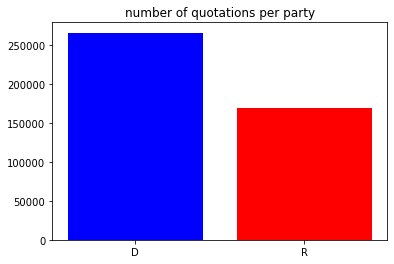

In [12]:
def plot_number_of_quotes_per_party(df):
    quotes_per_party = df[['party_label','quotation']].groupby('party_label').size().reset_index().rename(columns = {0: 'nb_quotes'})
    display(quotes_per_party)
    plt.bar(quotes_per_party.party_label,quotes_per_party.nb_quotes,color = ['blue','red'])
    plt.title('number of quotations per party')
plot_number_of_quotes_per_party(df)

In [21]:
## arguments:
    ## dataframe: dataframe containing quotes, the data frame must have at least 2 columns: 'party_label' and ' quotation'
    ## keyword: only used if use_keyword = True, allows us to do analysis with only quotes that include the keyword
    ## use_keyword: specifies if we must use the keyword to to do analysis with only quotes that include the keyword
    ##removeVerbs: if set to true, we remove all verbs from the quotes
    ## top: the number of trending words that will be shown on plot 
def trending_words(dataframe, keyword = None, use_keyword = False, removeVerbs = False,show_biggest_deltas = False ,top = 20):
    """ function that plots on a bar plot the top trending words for every political party and compares it to the other partie's statistics """

    def compute_relative_proportion(pos_party, party_label, proportion):
        if pos_party != party_label:
            return -proportion
        else:
            return proportion

    df = dataframe.copy()

    if use_keyword:
        #keep only quotes that contain the keyword
        df = df[df['quotation'].str.contains(keyword)]

    ##clean the data, (removing stop words etc..)
    df['quotation'] = clean(df['quotation'])

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    ##count the top words per partylabel
    word_count = df.groupby('party_label')['quotation'].apply(hero.visualization.top_words)
    
    

    #rename columns
    word_count = word_count.reset_index().rename(columns = {'level_1': 'word', 'quotation': 'proportion'})
    
    word_count['proportion'] = word_count.groupby('party_label')['proportion'].apply(lambda x: x / float(x.sum()))

    #plot top trending words per party
    for party in word_count['party_label'].unique():

        if use_keyword:
            #drop keyword in the word frequencies
            party_top_words = word_count[word_count['word'] != keyword]

        else:
            party_top_words = word_count
        
        if show_biggest_deltas:
            #if party_label != party make the relative_proportion = -proportion otherwise make relative_proportion = proportion
            word_count['proportion'] = word_count.apply(lambda x: compute_relative_proportion(party, x['party_label'], x['proportion']),axis = 1)

            diff_table = word_count.groupby('word')['proportion'].apply(lambda x: sum(x)).reset_index()
            #sort word frequency in decreasing order
            party_top_words = diff_table.sort_values(by = 'proportion', ascending = False)
            word_count['proportion'] = word_count['proportion'].apply(lambda x: -x if x < 0 else x)
            
            

        else:
            #sort word frequency in decreasing order
            party_top_words = word_count[word_count['party_label'] == party].sort_values(by = 'proportion', ascending = False)
            

        ##get only the 'top' most frequent words
        party_top_words = party_top_words['word'].head(top)
        ##extract counts of the top trending words
        df_with_party_top_words = word_count[word_count['word'].isin(party_top_words)]
        
        #plot
        sns.barplot(data = df_with_party_top_words, y='word', x='proportion', hue='party_label').set_title('top trending words for ' + party + ' party')
        plt.show()




In [16]:
df =  pd.read_json(QUOTES_2020_PARTY_LABELED_CLEANED_PATH, lines=True, compression='bz2')

,word,proportion
35760,people,0.002632
32582,new,0.001788
8712,city,0.001328
21629,health,0.001007
7080,campaign,0.000929
...,...,...
8417,chinese,-0.000672
2050,american,-0.000762
22610,house,-0.000791
8410,china,-0.001009


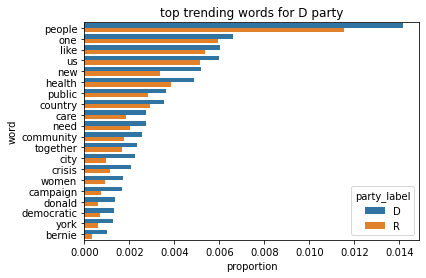

,word,proportion
37513,president,0.001360
8410,china,0.001009
22610,house,0.000791
2050,american,0.000762
8417,chinese,0.000672
...,...,...
7080,campaign,-0.000929
21629,health,-0.001007
8712,city,-0.001328
32582,new,-0.001788


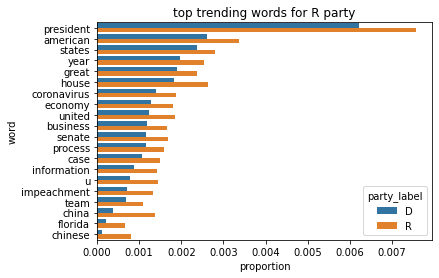

In [23]:
trending_words(df, keyword = None, use_keyword = False,removeVerbs = True,show_biggest_deltas = True,top = 20)

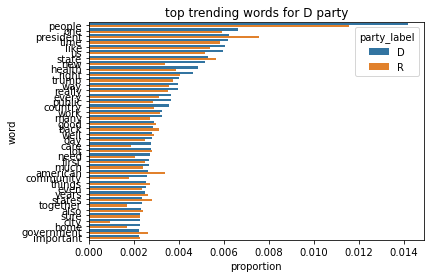

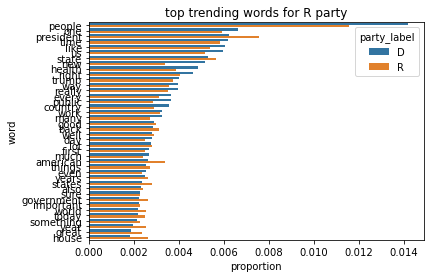

In [ ]:
trending_words(df,removeVerbs = True,show_biggest_deltas = False,top = 20)

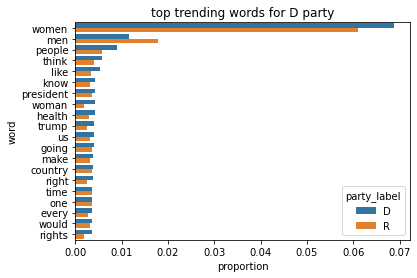

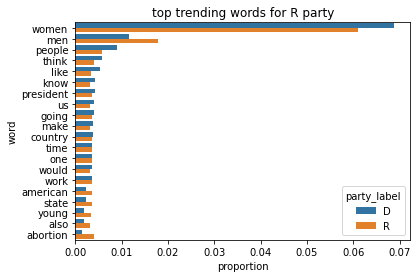

In [24]:
trending_words(df, keyword = 'women', use_keyword = True, removeVerbs = False, top = 20)

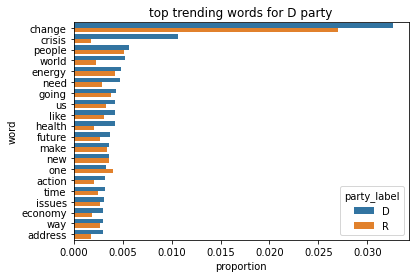

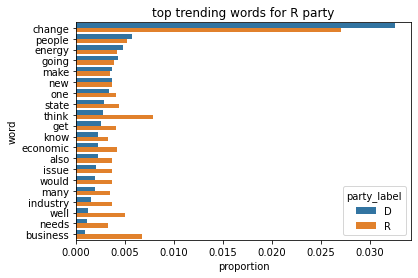

In [ ]:
trending_words(df, keyword = 'climate', use_keyword = True, removeVerbs = False, top = 20)

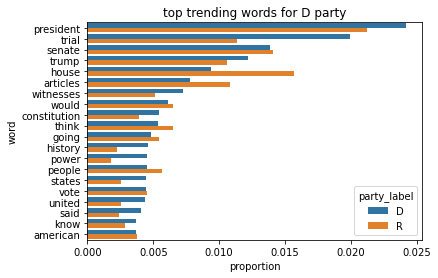

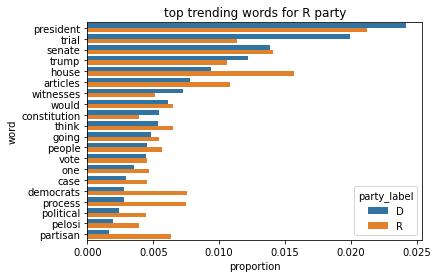

In [ ]:
trending_words(df, keyword = 'impeachment', use_keyword = True, removeVerbs = False, top = 20)